# Analysis of Lithium Export and Import

This notebook explores the export and import trends of lithium across different countries and regions. The aim is to provide insights into global lithium trade patterns, including major exporters, importers, and the overall trade balance.

---

## Table of Contents

1. [Introduction](#Introduction)
2. [Data Loading and Preparation](#Data-Loading-and-Preparation)
3. [Top Trading Countries](#Top-Trading-Countries)
4. [Ranked Trading Countries](#Ranked-Trading-Countries)
5. [Map Visualizations](#Map-Visualizations)



In [1]:
# General Utilities
import os
import warnings
from pathlib import Path

# Numerical and Data Processing
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.legend_handler import HandlerBase
from matplotlib.image import BboxImage
from matplotlib.transforms import Bbox, TransformedBbox
import matplotlib.lines as mlines

# Geospatial Data
import geopandas as gpd

# Custom Modules
from dataloader import DataLoader

# Set global visualization and warning options
warnings.filterwarnings("ignore")

### Data Loading and Preparation

In [2]:
# Load and preprocess dataset
hs_code = 282520
hs_label = "Lithium"

In [3]:
# Create dir for exporting plots
export_path = os.path.join("figures", hs_label)
Path(export_path).mkdir(parents=True, exist_ok=True)

In [4]:
# Load and preprocess dataset
loader = DataLoader(hs_code=hs_code)

_initialize_data took 46.1213 seconds


In [5]:
# Returns efficiently handled polar dataframe
df = loader.get_data()

In [6]:
# Extracts the distinct years
years = sorted(df['t'].unique())

In [7]:
# Get aggregated export and import over all products
baseline_df = loader.get_baseline(load_precompute=True)

In [8]:
# Get Networkx representation of baseline_df
yearly_graphs = loader.get_yearly_graphs(years)

In [9]:
yearly_baseline_graph = loader.get_yearly_baseline_graphs(baseline_df, years)

In [10]:
df

,t,export_country,import_country,v,q
0,2002,Australia,Canada,7.627,2.211
1,2002,Australia,Indonesia,15.395,1.120
2,2002,Australia,Ireland,1.874,0.008
3,2002,Australia,Italy,2.748,0.003
4,2002,Australia,New Zealand,5.832,1.422
...,...,...,...,...,...
9944,2022,United States of America,United Kingdom,7347.733,116.959
9945,2022,United States of America,Vietnam,147.514,3.382
9946,2022,Vietnam,South Korea,3.128,0.050
9947,2022,Zimbabwe,China,40.688,4.192


In [11]:
baseline_df

,t,export_country,import_country,v
0,2001,Afghanistan,Algeria,51.995
1,2001,Afghanistan,Andorra,7.921
2,2001,Afghanistan,Anguilla,0.275
3,2001,Afghanistan,Argentina,0.764
4,2001,Afghanistan,Australia,19.359
...,...,...,...,...
643197,2022,eSwatini,United Republic of Tanzania,42002.308
643198,2022,eSwatini,United States of America,13922.881
643199,2022,eSwatini,Uruguay,0.798
643200,2022,eSwatini,Uzbekistan,0.849


### Top Trading Countries

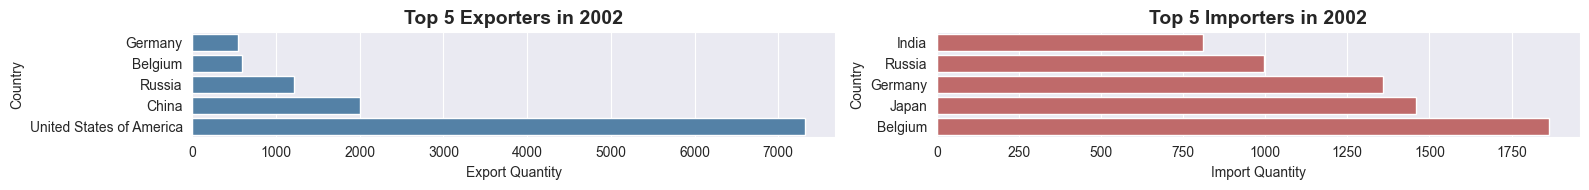

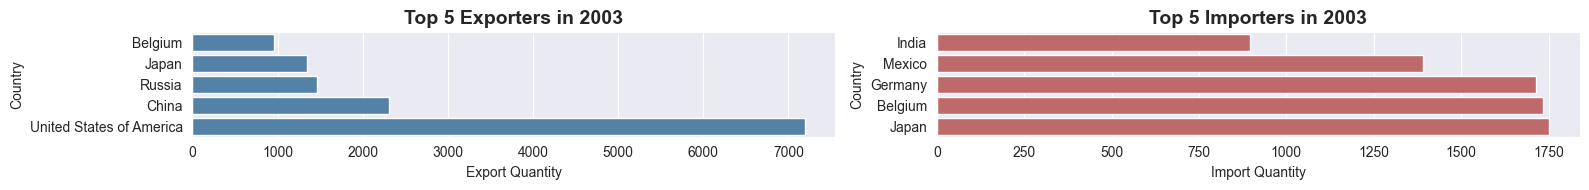

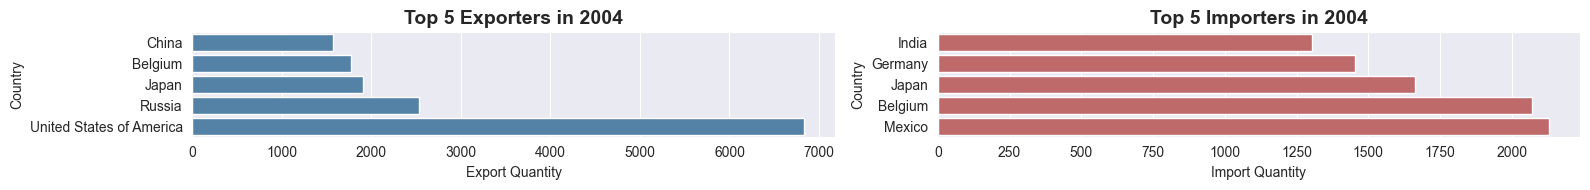

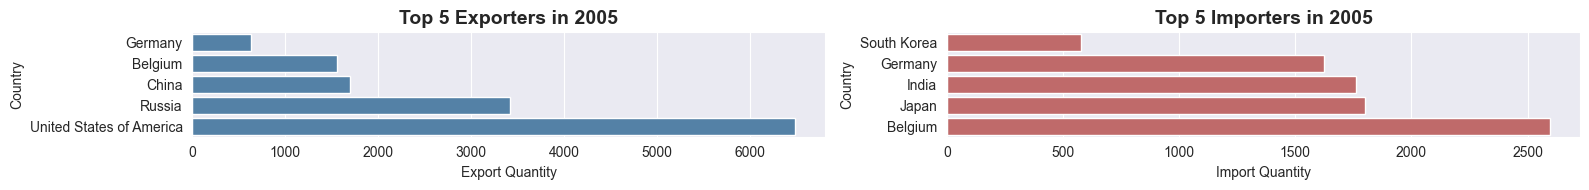

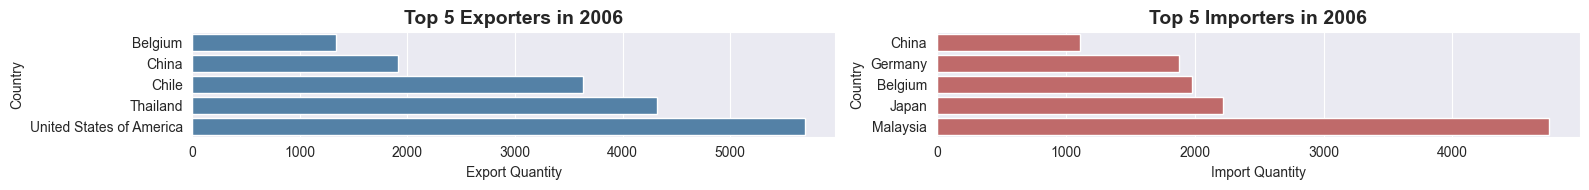

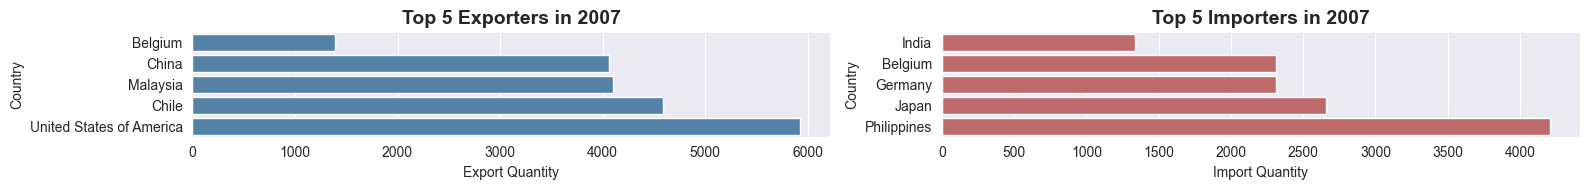

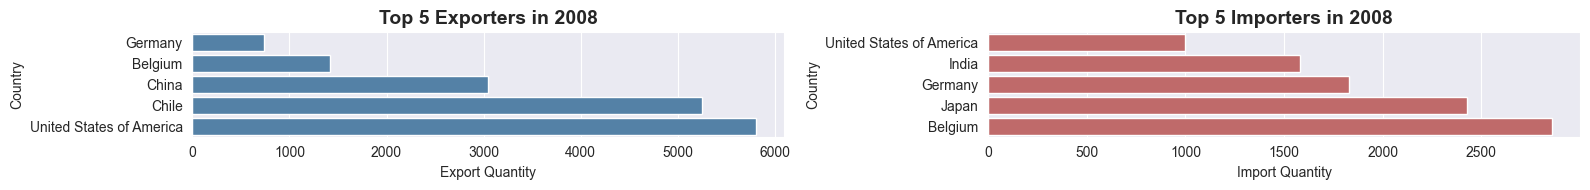

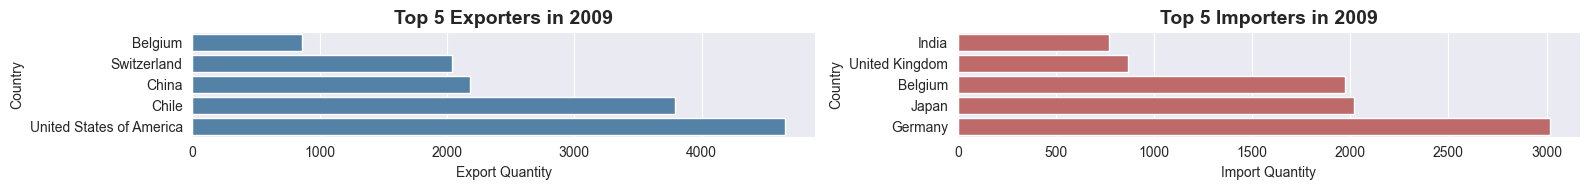

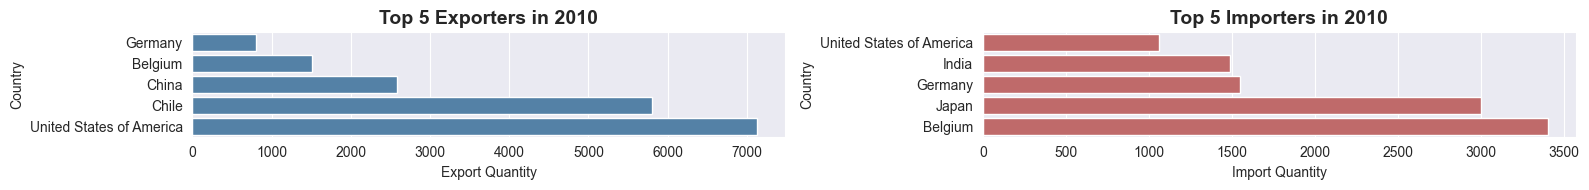

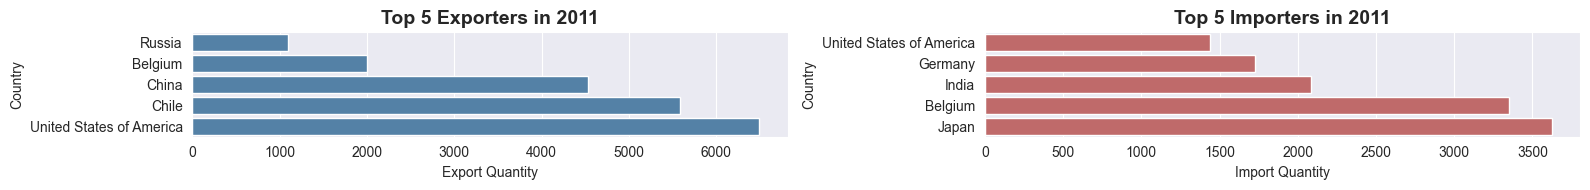

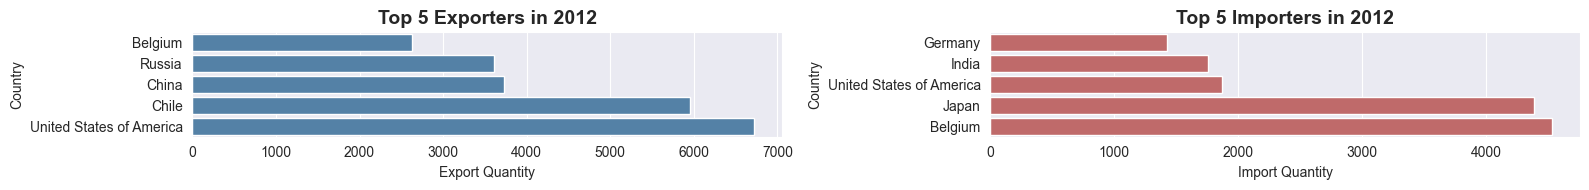

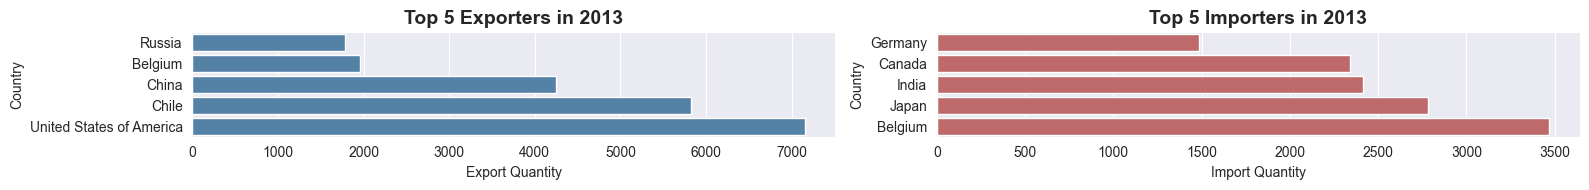

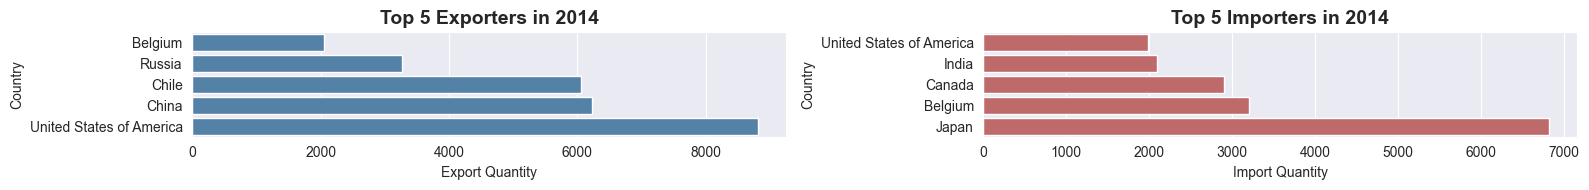

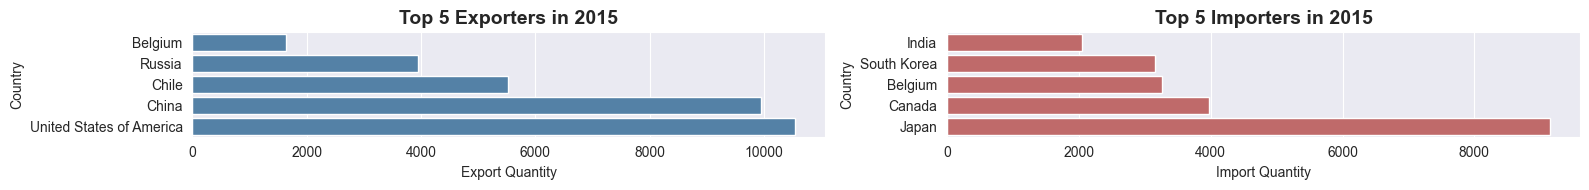

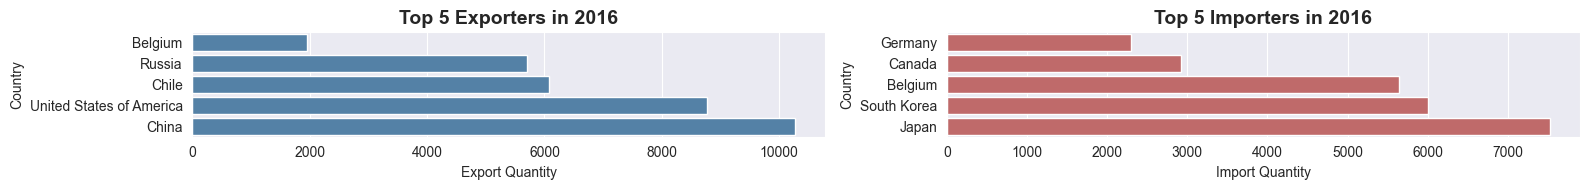

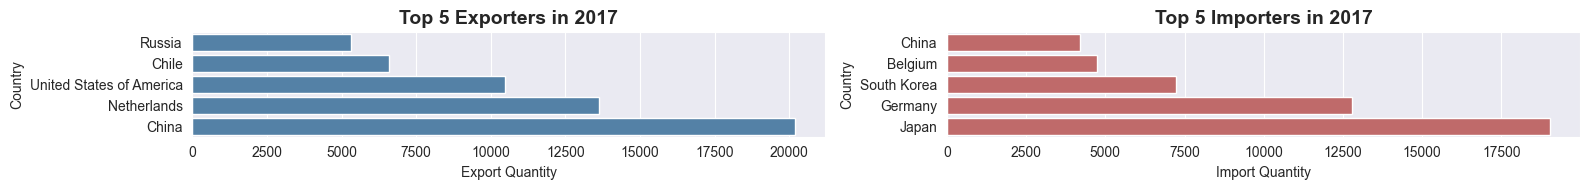

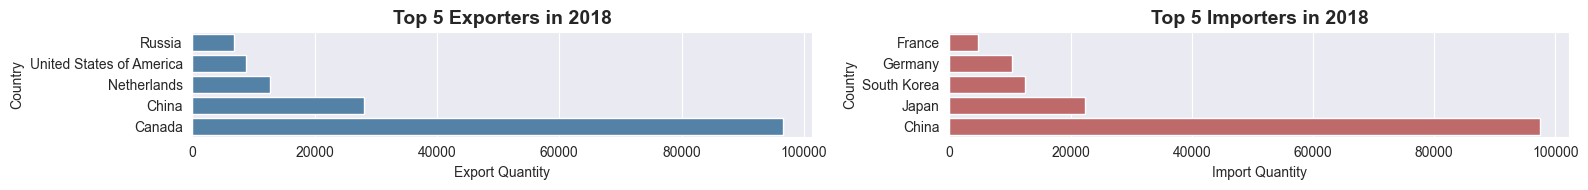

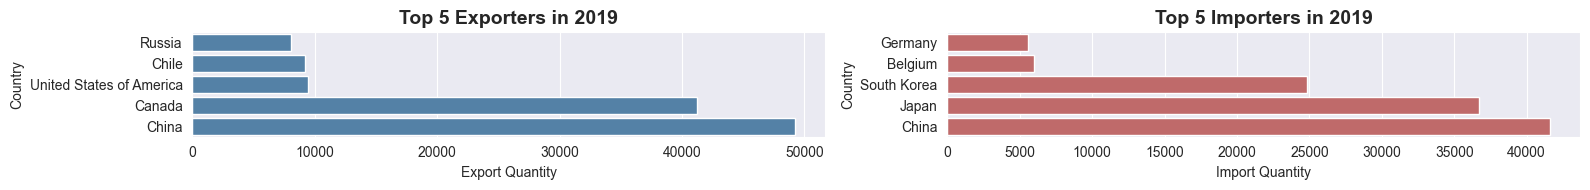

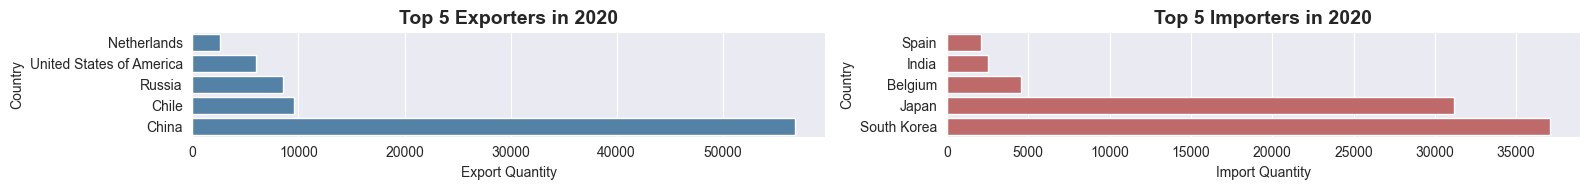

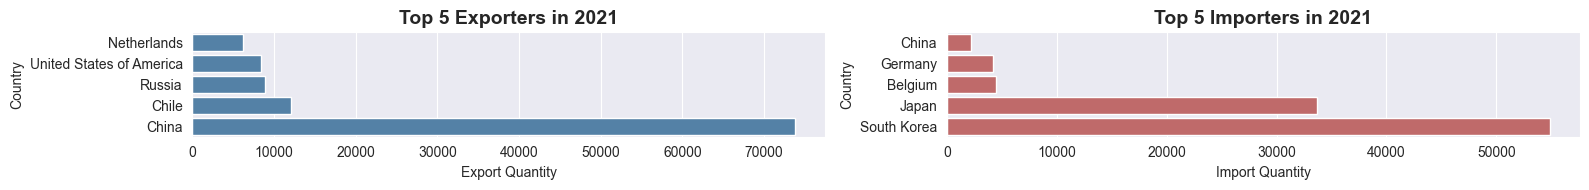

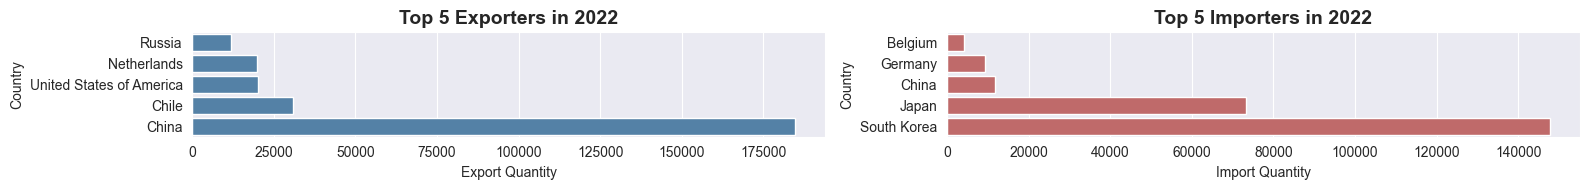

In [12]:
top_n = 5
for y in years:
    df_year = df[df['t'] == y]

    # Aggregation by Exporter
    exports = df_year.groupby("export_country")['q'].sum().reset_index()
    exports = exports.sort_values('q', ascending=False).head(top_n)

    # Aggregation by Importer
    imports = df_year.groupby("import_country")['q'].sum().reset_index()
    imports = imports.sort_values('q', ascending=False).head(top_n)

    fig, axs = plt.subplots(1, 2, figsize=(16,2))

    # Visualization of Exporters
    exports = exports.sort_values('q')
    sns.barplot(x='q', y='export_country', data=exports, ax=axs[0], color='steelblue')
    axs[0].set_title(f"Top {top_n} Exporters in {y}", fontsize=14, fontweight='bold')
    axs[0].set_xlabel("Export Quantity")
    axs[0].set_ylabel("Country")

    # Visualization of Importers
    imports = imports.sort_values('q')
    sns.barplot(x='q', y='import_country', data=imports, ax=axs[1], color='indianred')
    axs[1].set_title(f"Top {top_n} Importers in {y}", fontsize=14, fontweight='bold')
    axs[1].set_xlabel("Import Quantity")
    axs[1].set_ylabel("Country")

    plt.tight_layout()
    plt.show()


### Ranked Trading Countries

In [13]:
class HandlerLineImage(HandlerBase):
    def __init__(self, path, space=10, offset=0):
        self.space = space
        self.offset = offset
        self.image_data = plt.imread(path)
        super().__init__()

    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        line = mlines.Line2D([xdescent + self.offset, xdescent + (width - self.space) / 3. + self.offset],
                             [ydescent + height / 2., ydescent + height / 2.],
                             color=orig_handle.get_color(),
                             lw=orig_handle.get_linewidth(),
                             linestyle=orig_handle.get_linestyle())
        line.set_clip_on(False)
        line.set_transform(trans)

        bbox = Bbox.from_bounds(xdescent + (width + self.space) / 3. + self.offset,
                                ydescent,
                                height * self.image_data.shape[1] / self.image_data.shape[0],
                                height)
        t_bbox = TransformedBbox(bbox, trans)
        image = BboxImage(t_bbox)
        image.set_data(self.image_data)
        self.update_prop(image, orig_handle, legend)

        return [line, image]


def get_flag_path(country_code: str) -> str:
    return os.path.join("data/dataset", "png100px", f"{country_code.lower()}.png")


def add_flag_to_chart(ax, x, y, country_code, zoom=0.15):
    flag_path = get_flag_path(country_code)
    try:
        img = plt.imread(flag_path)
        im = OffsetImage(img, zoom=zoom)
        ab = AnnotationBbox(im, (x, y), frameon=False)
        ax.add_artist(ab)
    except FileNotFoundError:
        print(f"Flag image not found for {country_code} and path {flag_path}")


def create_bump_chart_with_flags(df, category, top_n, value_col="v", time_col="t", figsize=(14, 6), palette="tab20"):
    df_grouped = (
        df.groupby([time_col, category])[value_col]
        .sum()
        .reset_index()
        .sort_values(by=[time_col, value_col], ascending=[True, False])
    )

    df_grouped['rank'] = (
        df_grouped.groupby(time_col)[value_col]
        .rank(method='first', ascending=False)
        .astype(int)
    )

    df_top = df_grouped[df_grouped['rank'] <= top_n]
    df_pivot = df_top.pivot(index=category, columns=time_col, values='rank')
    df_pivot = df_pivot.loc[df_pivot.min(axis=1).sort_values().index]
    fig, ax = plt.subplots(figsize=figsize)
    colors = sns.color_palette(palette, len(df_pivot))

    legend_handlers = {}
    for idx, (row, color) in enumerate(zip(df_pivot.iterrows(), colors)):

        category_name = row[0]
        country_code = loader.get_country_code(category_name)

        line, = ax.plot(
            df_pivot.columns, row[1], label=category_name,
            lw=3.5, markersize=0, alpha=0.85, color=color, zorder=1
        )
        for x, y in zip(df_pivot.columns, row[1]):
            if country_code:
                add_flag_to_chart(ax, x, y, country_code, zoom=0.15)
        if country_code:
            flag_path = get_flag_path(country_code)
            legend_handlers[line] = HandlerLineImage(flag_path)
    ax.invert_yaxis()
    ax.set_xticks(df_pivot.columns)
    ax.set_yticks(range(1, top_n + 1))
    ax.set_xticklabels(df_pivot.columns, fontsize=12, rotation=45)
    ax.set_yticklabels(range(1, top_n + 1), fontsize=12)
    ax.set_title(f"Top {top_n} {category.split('_')[0].title()}ers", fontsize=18, fontweight='bold', pad=20)
    ax.set_xlabel("Year", fontsize=14, labelpad=15)
    ax.set_ylabel("Rank", fontsize=14, labelpad=15)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    legend = ax.legend(
        loc='lower center',
        bbox_to_anchor=(0.5, -0.5),
        title=" ".join(category.split("_")).title(),
        fontsize=10,
        title_fontsize=12,
        handler_map=legend_handlers,
        ncol=8
    )
    plt.subplots_adjust(bottom=0.5)
    plt.tight_layout()
    output_file = os.path.join(export_path, f"{hs_label}_bump_chart_{category}_{top_n}.png")
    plt.savefig(output_file, dpi=300, bbox_inches='tight', bbox_extra_artists=[legend])
    plt.show()


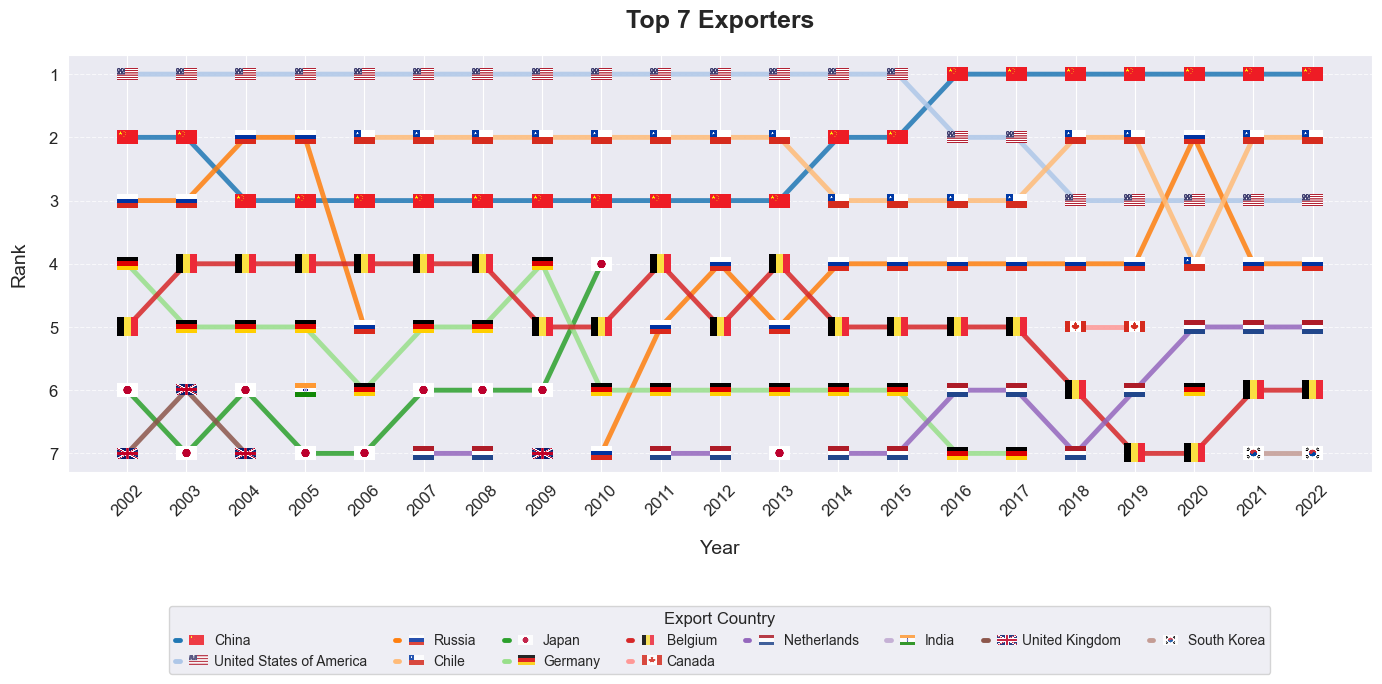

In [14]:
create_bump_chart_with_flags(
    df=df,
    category='export_country',
    top_n=7,
)

### Top Importers

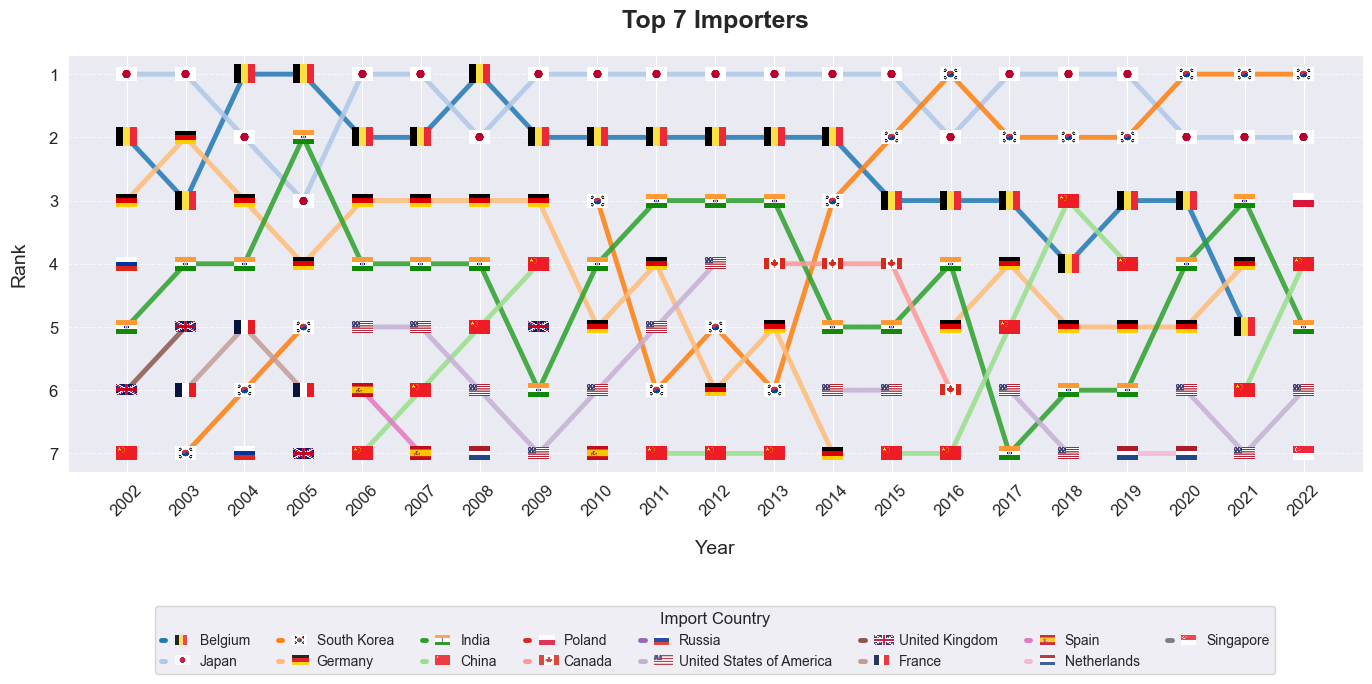

In [15]:
create_bump_chart_with_flags(
    df=df,
    category='import_country',
    top_n=7,
)

### Map Visualizations

In [16]:
gray_blue_cmap = mcolors.LinearSegmentedColormap.from_list(
    "gray_blue",
    ["gray", "blue"]
)

gray_red_cmap = mcolors.LinearSegmentedColormap.from_list(
    "gray_red",
    ["gray", "red"]
)

Unmapped Names: Singapore, Curaçao, Barbados, Cook Isds, Andorra
Unmapped Names: Bermuda, Maldives, Comoros, Br. Virgin Isds, Lao People's Dem. Rep., Cabo Verde, Andorra, Kiribati, Barbados, Singapore, Montserrat, Côte d'Ivoire, Cayman Isds, Bahrain, Palau, Samoa, Seychelles


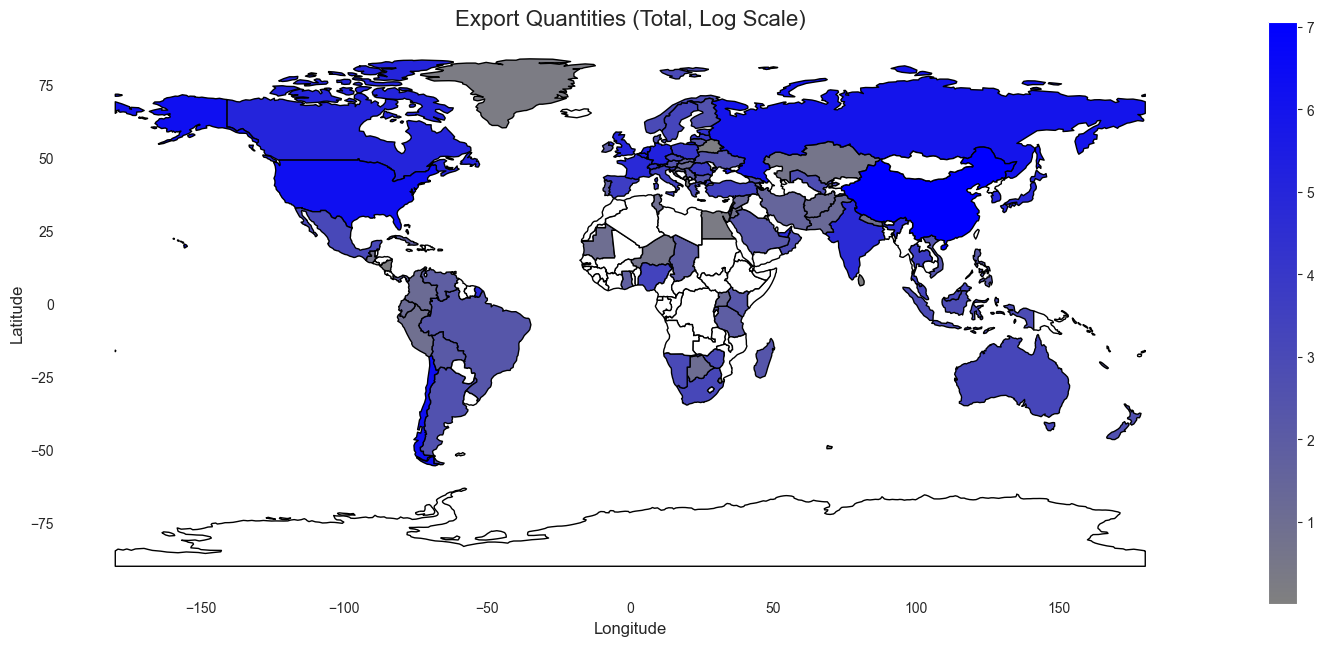

In [17]:
def plot_export_map():
    world_export, _ = loader.preprocess_culture_and_country_names(df)
    world_export["v"] = np.log10(world_export["v"] + 1)

    fig, ax = plt.subplots(figsize=(15, 10))
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')

    world_export.plot(
        column="v",
        cmap=gray_blue_cmap,
        legend=True,
        legend_kwds={"shrink": 0.6, "aspect": 20},
        ax=ax,
        missing_kwds={"color": "white"},
        edgecolor="black"
    )
    ax.set_title("Export Quantities (Total, Log Scale)", fontsize=16)
    ax.set_xlabel("Longitude", fontsize=12)
    ax.set_ylabel("Latitude", fontsize=12)

    plt.tight_layout()
    plt.savefig(os.path.join(export_path, f"{hs_label}_export_map.png"), dpi=300, facecolor='white')
    plt.show()

plot_export_map()

Unmapped Names: Singapore, Curaçao, Barbados, Cook Isds, Andorra
Unmapped Names: Bermuda, Maldives, Comoros, Br. Virgin Isds, Lao People's Dem. Rep., Cabo Verde, Andorra, Kiribati, Barbados, Singapore, Montserrat, Côte d'Ivoire, Cayman Isds, Bahrain, Palau, Samoa, Seychelles


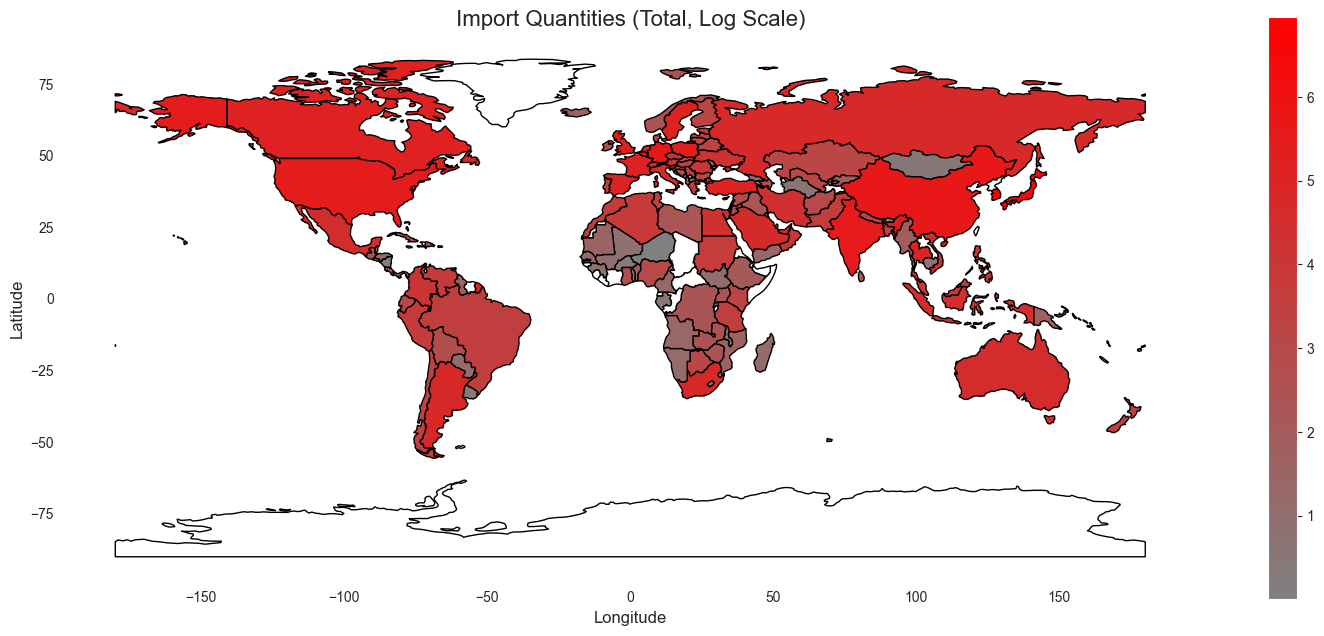

In [18]:
def plot_import_map():
    _, world_import = loader.preprocess_culture_and_country_names(df)
    world_import["v"] = np.log10(world_import["v"] + 1)

    fig, ax = plt.subplots(figsize=(15, 10))
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')

    world_import.plot(
        column="v",
        cmap=gray_red_cmap,
        legend=True,
        legend_kwds={"shrink": 0.6, "aspect": 20},
        ax=ax,
        missing_kwds={"color": "white"},
        edgecolor="black"
    )
    ax.set_title("Import Quantities (Total, Log Scale)", fontsize=16)
    ax.set_xlabel("Longitude", fontsize=12)
    ax.set_ylabel("Latitude", fontsize=12)

    plt.tight_layout()
    plt.savefig(os.path.join(export_path, f"{hs_label}_import_map.png"), dpi=300, facecolor='white')

    plt.show()

plot_import_map()

Unmapped Names: Singapore, Curaçao, Barbados, Cook Isds, Andorra
Unmapped Names: Bermuda, Maldives, Comoros, Br. Virgin Isds, Lao People's Dem. Rep., Cabo Verde, Andorra, Kiribati, Barbados, Singapore, Montserrat, Côte d'Ivoire, Cayman Isds, Bahrain, Palau, Samoa, Seychelles


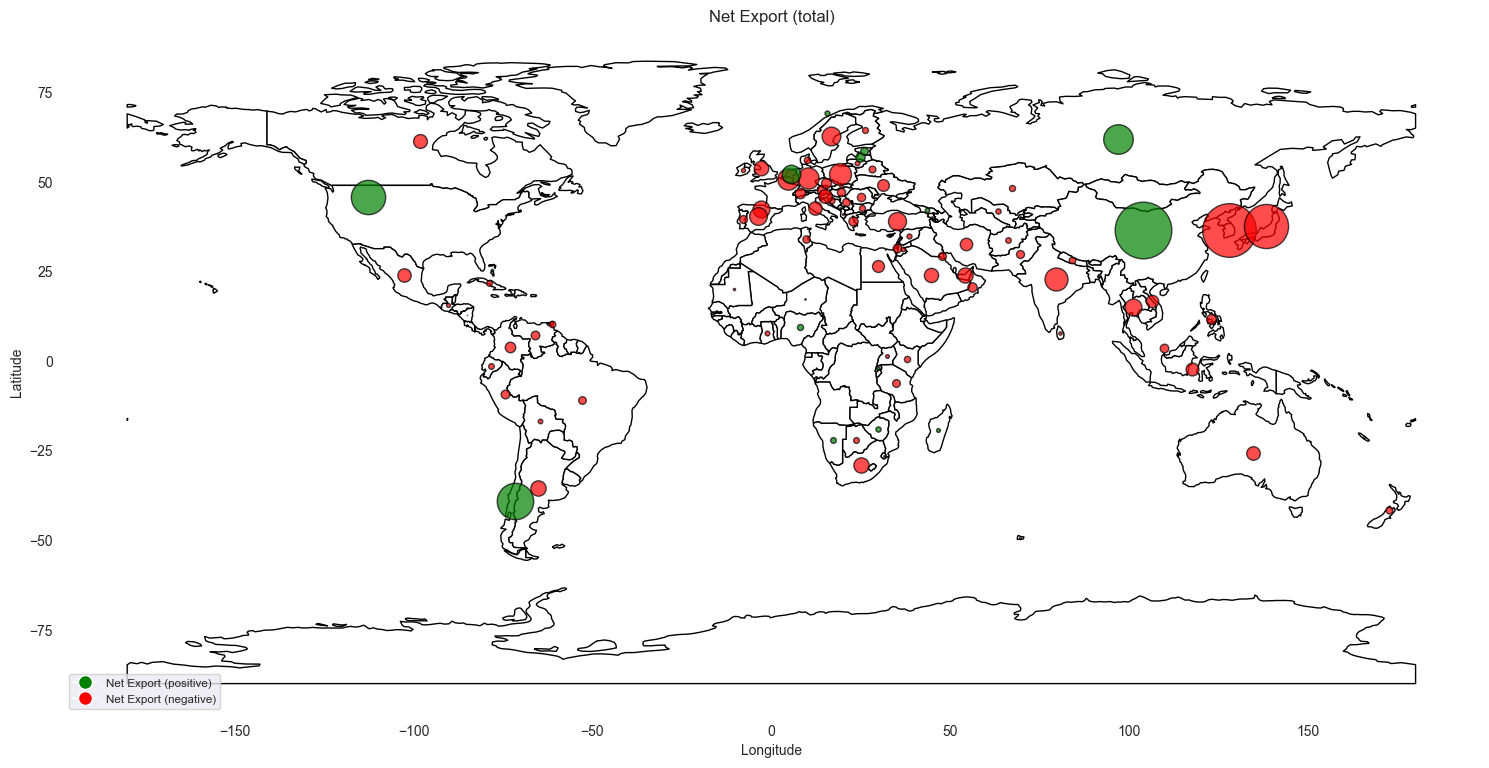

In [19]:
def plot_map_2():
    shapefile_path = os.path.join("data/dataset", "110m_cultural", "ne_110m_admin_0_countries.shp")
    world = gpd.read_file(shapefile_path)
    world_export, world_import = loader.preprocess_culture_and_country_names(df)

    net_export = (
        world_export.set_index("export_country")["v"]
        - world_import.set_index("import_country")["v"]
    ).reset_index()
    net_export.columns = ["country", "net_export"]

    world_net = world.merge(net_export, left_on="ADMIN", right_on="country", how="left")

    fig, ax = plt.subplots(1, 1, figsize=(15, 10))

    world.plot(ax=ax, color="white", edgecolor="black")
    ax.set_facecolor('none')

    for _, row in world_net.iterrows():
        if pd.notnull(row["net_export"]) and row["net_export"] != 0:
            size = np.sqrt(abs(row["net_export"])) / 2
            color = "green" if row["net_export"] > 0 else "red"
            ax.scatter(
                row.geometry.centroid.x,
                row.geometry.centroid.y,
                s=size,
                color=color,
                alpha=0.7,
                edgecolor="black"
            )

    handles = [
        plt.Line2D([0], [0], marker="o", color="w", markerfacecolor="green", markersize=10, label="Net Export (positive)"),
        plt.Line2D([0], [0], marker="o", color="w", markerfacecolor="red", markersize=10, label="Net Export (negative)"),
    ]
    ax.legend(handles=handles, loc="lower left", fontsize="small")

    ax.set_title(f"Net Export (total)")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

    plt.tight_layout()
    plt.savefig(os.path.join(export_path, f"{hs_label}_net_export_map_2.png"), dpi=300, transparent=True)
    plt.show()

plot_map_2()


Unmapped Names: Singapore, Curaçao, Barbados, Cook Isds, Andorra
Unmapped Names: Bermuda, Maldives, Comoros, Br. Virgin Isds, Lao People's Dem. Rep., Cabo Verde, Andorra, Kiribati, Barbados, Singapore, Montserrat, Côte d'Ivoire, Cayman Isds, Bahrain, Palau, Samoa, Seychelles


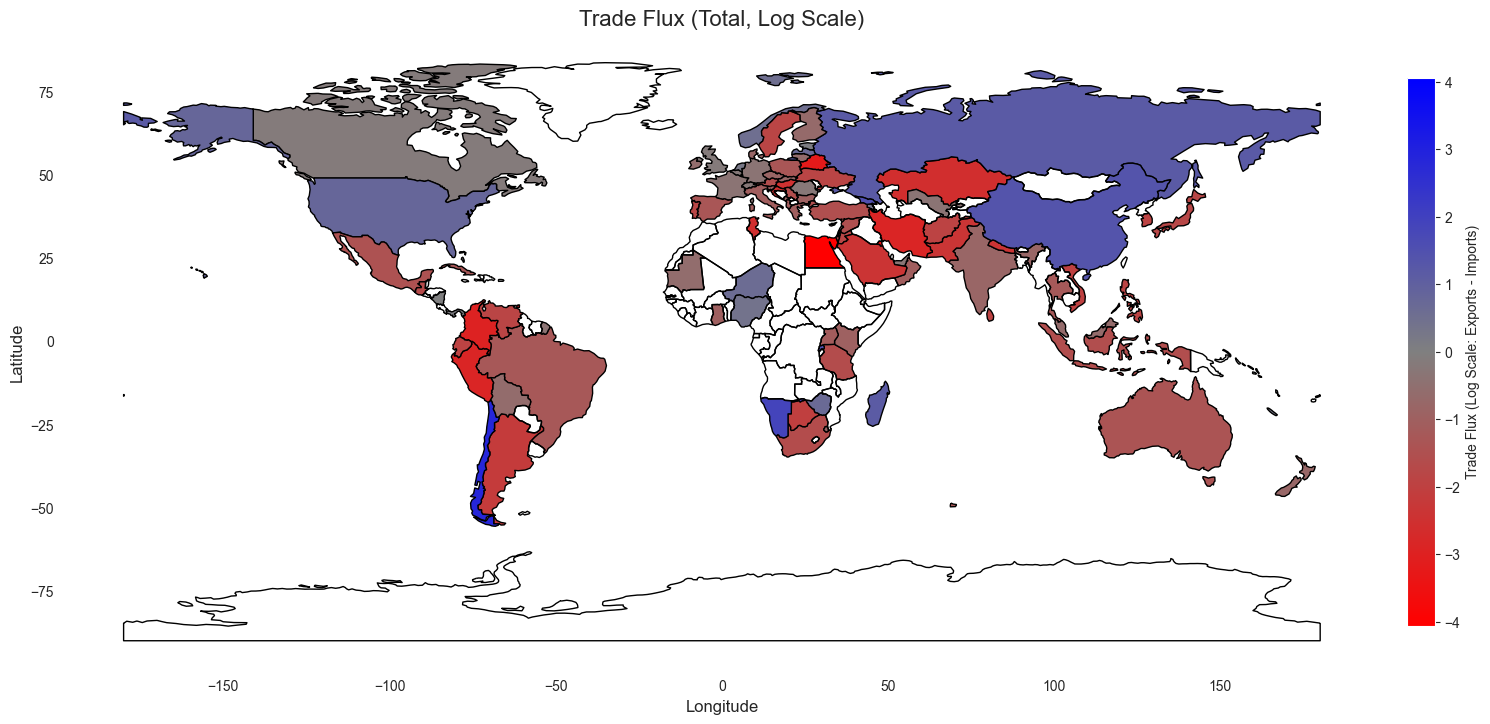

In [20]:
def plot_flux():
    world_export, world_import = loader.preprocess_culture_and_country_names(df)

    world_export["v"] = np.log10(world_export["v"] + 1)
    world_import["v"] = np.log10(world_import["v"] + 1)

    world_flux = world_export[["ADMIN", "geometry", "v"]].merge(
        world_import[["ADMIN", "v"]], on="ADMIN", suffixes=("_exp", "_imp")
    )
    world_flux["flux"] = world_flux["v_exp"] - world_flux["v_imp"]

    vmax = world_flux["flux"].abs().max()

    flux_cmap = mcolors.LinearSegmentedColormap.from_list("flux_cmap", ["red", "gray", "blue"])
    norm = mcolors.Normalize(vmin=-vmax, vmax=vmax)

    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    fig.patch.set_alpha(0)
    ax.set_facecolor((0, 0, 0, 0))

    world_flux.plot(
        column="flux",
        cmap=flux_cmap,
        norm=norm,
        legend=False,
        ax=ax,
        missing_kwds={"color": "none"},
        edgecolor="black"
    )

    sm = plt.cm.ScalarMappable(norm=norm, cmap=flux_cmap)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, orientation="vertical", fraction=0.02, pad=0.02)
    cbar.set_label("Trade Flux (Log Scale: Exports - Imports)")

    ax.set_title(f"Trade Flux (Total, Log Scale)", fontsize=16)
    ax.set_xlabel("Longitude", fontsize=12)
    ax.set_ylabel("Latitude", fontsize=12)

    plt.tight_layout()
    plt.savefig(
        os.path.join(export_path, f"{hs_label}_trade_flux_map.png"),
        dpi=300,
        transparent=True
    )
    plt.show()

plot_flux()
